<a href="https://colab.research.google.com/github/Devlaxman93/Neurohackers/blob/experimental-code/Steinmetz_SC_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [20]:
# !pip install git+https://github.com/ahwillia/tensortools

  Cloning https://github.com/ahwillia/tensortools to /tmp/pip-req-build-gx1bz6u7
  Running command git clone -q https://github.com/ahwillia/tensortools /tmp/pip-req-build-gx1bz6u7
  Created wheel for tensortools: filename=tensortools-0.3-cp36-none-any.whl size=26267 sha256=ae7a0d6335c94ebffec5dc4daa7a5e48751b2cc9528ac09e9358dc1d8cc403bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-wu3lzxwi/wheels/e4/4f/c6/b7ea145adb6874a9583dfe0c5c8ef3048335f4f885c6ee01ac
Successfully built tensortools


In [21]:
#@title Data loading
import numpy as np
from scipy.ndimage import gaussian_filter1d
import tensortools as tt

In [ ]:
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


In [16]:
# filtering data by desired brain region: SCs
# only trials with correct response are included 
# minimum number of correct trials: 180
# data is smoothed with Gaussian filter of 1.5 SD
min_trials = 180
filtered_dat = []
smoothed_dat = []
for i in range(alldat.shape[0]):
  area = alldat[i]['brain_area']
  response = alldat[i]['response'] # right - nogo - left (-1, 0, 1)
  vis_right = alldat[i]['contrast_right'] # 0 - low - high
  vis_left = alldat[i]['contrast_left'] # 0 - low - high
  is_correct = np.sign(response)==np.sign(vis_left-vis_right) 
  f_dat = alldat[i]['spks'][area=='SCs'][:, is_correct, :]
  # print(f_dat.shape)
  if (f_dat.shape[0] > 0) and f_dat.shape[1] >= min_trials:
    f_dat = f_dat[:, :min_trials, :]
    # finds SD of each neuron and applies Gaussian filter
    for j in range(f_dat.shape[0]):
      sd = np.std(f_dat[j]) * 1.5
      f_dat_smooth = gaussian_filter1d(f_dat[j], sigma=sd, axis=-1)[np.newaxis, :]
      smoothed_dat.append(f_dat_smooth)
    f_dat = np.vstack(smoothed_dat)
    filtered_dat.append(f_dat)
joint_array = np.vstack(filtered_dat)
print(joint_array.shape)

(243, 180, 250)


CP_ALS: iteration 1, objective 0.999398666120648, improvement inf.
CP_ALS: iteration 2, objective 0.9913890593934397, improvement 0.008009606727208296.
CP_ALS: iteration 3, objective 0.984815414224197, improvement 0.006573645169242637.
CP_ALS: iteration 4, objective 0.9828271734024656, improvement 0.001988240821731435.
CP_ALS: iteration 5, objective 0.9816607275561061, improvement 0.0011664458463594984.
CP_ALS: iteration 6, objective 0.9805588869765358, improvement 0.0011018405795703012.
CP_ALS: iteration 7, objective 0.9797485133039878, improvement 0.0008103736725479926.
CP_ALS: iteration 8, objective 0.9794538299783562, improvement 0.00029468332563165056.
CP_ALS: iteration 9, objective 0.979358842026337, improvement 9.498795201912102e-05.
CP_ALS: iteration 10, objective 0.9793099708717958, improvement 4.887115454121904e-05.
CP_ALS: iteration 11, objective 0.9792739640405363, improvement 3.600683125948301e-05.
CP_ALS: iteration 12, objective 0.9792436841592822, improvement 3.027988125

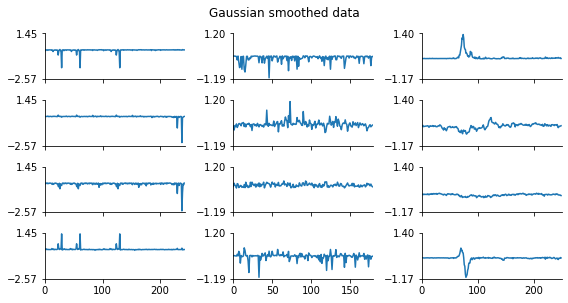

In [23]:
# TCA decomposition of the data
R = 4
U = tt.cp_als(joint_array, rank=R, verbose=True)
fig, ax, po = tt.plot_factors(U.factors)
fig.figsize=(12,10)
fig.suptitle("Gaussian smoothed data",y=1.04)
fig.tight_layout()